In [1]:
#  Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#  Install required libraries
!pip install scikit-learn xgboost joblib pandas numpy matplotlib seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.8/296.8 MB 1.3 MB/s eta 0:00:00


In [3]:
#  Import libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix)
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [4]:
#  Set data path
data_path = '/content/drive/MyDrive/SentiCare_Project/01_Preprocessed_Data'

In [5]:
# Load full assessment data (33 features)
X_train_full = pd.read_csv(f'{data_path}/X_train_full_scaled.csv')
X_val_full = pd.read_csv(f'{data_path}/X_val_full_scaled.csv')
X_test_full = pd.read_csv(f'{data_path}/X_test_full_scaled.csv')

y_train = pd.read_csv(f'{data_path}/y_train.csv')
y_val = pd.read_csv(f'{data_path}/y_val.csv')
y_test = pd.read_csv(f'{data_path}/y_test.csv')

print(f"X_train_full: {X_train_full.shape}")
print(f"X_val_full: {X_val_full.shape}")
print(f"X_test_full: {X_test_full.shape}")
print(f"y_train: {y_train.shape}")

X_train_full: (7411, 33)
X_val_full: (1588, 33)
X_test_full: (1589, 33)
y_train: (7411, 2)


In [6]:
#  Load real-time data (6 features)
X_train_realtime = pd.read_csv(f'{data_path}/X_train_realtime_scaled.csv')
X_val_realtime = pd.read_csv(f'{data_path}/X_val_realtime_scaled.csv')
X_test_realtime = pd.read_csv(f'{data_path}/X_test_realtime_scaled.csv')

print(f"X_train_realtime: {X_train_realtime.shape}")
print(f"X_val_realtime: {X_val_realtime.shape}")
print(f"X_test_realtime: {X_test_realtime.shape}")

X_train_realtime: (7411, 6)
X_val_realtime: (1588, 6)
X_test_realtime: (1589, 6)


In [7]:
# Extract targets
y_train_reg = y_train['Anxiety_Level'].values
y_val_reg = y_val['Anxiety_Level'].values
y_test_reg = y_test['Anxiety_Level'].values

y_train_class = y_train['Anxiety_Category'].values
y_val_class = y_val['Anxiety_Category'].values
y_test_class = y_test['Anxiety_Category'].values

print(f"Regression target: {y_train_reg.shape}")
print(f"Classification target: {y_train_class.shape}")
print(f"Class distribution: {pd.Series(y_train_class).value_counts()}")

Regression target: (7411,)
Classification target: (7411,)
Class distribution: mild        3624
moderate    3255
severe       532
Name: count, dtype: int64


In [9]:
#  Train baseline Random Forest (Full Assessment Model)
print("="*60)
print("MODEL 1: FULL ASSESSMENT (Random Forest Regressor)")
print("="*60)

rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train_full, y_train_reg)

y_pred_val = rf_baseline.predict(X_val_full)
# Fix: Removed 'squared=False' and applied np.sqrt() for RMSE calculation
rmse_val = np.sqrt(mean_squared_error(y_val_reg, y_pred_val))
mae_val = mean_absolute_error(y_val_reg, y_pred_val)
r2_val = r2_score(y_val_reg, y_pred_val)

print(f"Validation RMSE: {rmse_val:.3f}")
print(f"Validation MAE: {mae_val:.3f}")
print(f"Validation R²: {r2_val:.3f}")

MODEL 1: FULL ASSESSMENT (Random Forest Regressor)
Validation RMSE: 0.680
Validation MAE: 0.567
Validation R²: 0.864


In [11]:
#  Hyperparameter tuning Random Forest
print("Tuning Random Forest hyperparameters...")

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_full, y_train_reg)
best_rf = grid_search.best_estimator_

print(f"Best parameters: {grid_search.best_params_}")

y_pred_val_tuned = best_rf.predict(X_val_full)
# Fix: Removed 'squared=False' and applied np.sqrt() for RMSE calculation
rmse_tuned = np.sqrt(mean_squared_error(y_val_reg, y_pred_val_tuned))
mae_tuned = mean_absolute_error(y_val_reg, y_pred_val_tuned)
r2_tuned = r2_score(y_val_reg, y_pred_val_tuned)

print(f"Tuned Validation RMSE: {rmse_tuned:.3f}")
print(f"Tuned Validation MAE: {mae_tuned:.3f}")
print(f"Tuned Validation R²: {r2_tuned:.3f}")

Tuning Random Forest hyperparameters...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Tuned Validation RMSE: 0.672
Tuned Validation MAE: 0.561
Tuned Validation R²: 0.867


In [13]:
# Cell 10: Final evaluation on test set
y_pred_test = best_rf.predict(X_test_full)
rmse_test = np.sqrt(mean_squared_error(y_test_reg, y_pred_test))
mae_test = mean_absolute_error(y_test_reg, y_pred_test)
r2_test = r2_score(y_test_reg, y_pred_test)

print("="*60)
print("FINAL TEST SET PERFORMANCE (Full Assessment Model)")
print("="*60)
print(f"Test RMSE: {rmse_test:.3f}")
print(f"Test MAE: {mae_test:.3f}")
print(f"Test R²: {r2_test:.3f}")

FINAL TEST SET PERFORMANCE (Full Assessment Model)
Test RMSE: 0.666
Test MAE: 0.557
Test R²: 0.870



Top 10 Most Important Features:
                         feature  importance
18      Anxiety_Category_Ordinal    0.910107
7            Stress Level (1-10)    0.028431
1                    Sleep Hours    0.011289
3       Caffeine Intake (mg/day)    0.008054
17                Lifestyle_Risk    0.005722
2   Physical Activity (hrs/week)    0.004433
16           Physiological_Score    0.004372
13  Therapy Sessions (per month)    0.003993
8               Heart Rate (bpm)    0.003788
0                            Age    0.003635


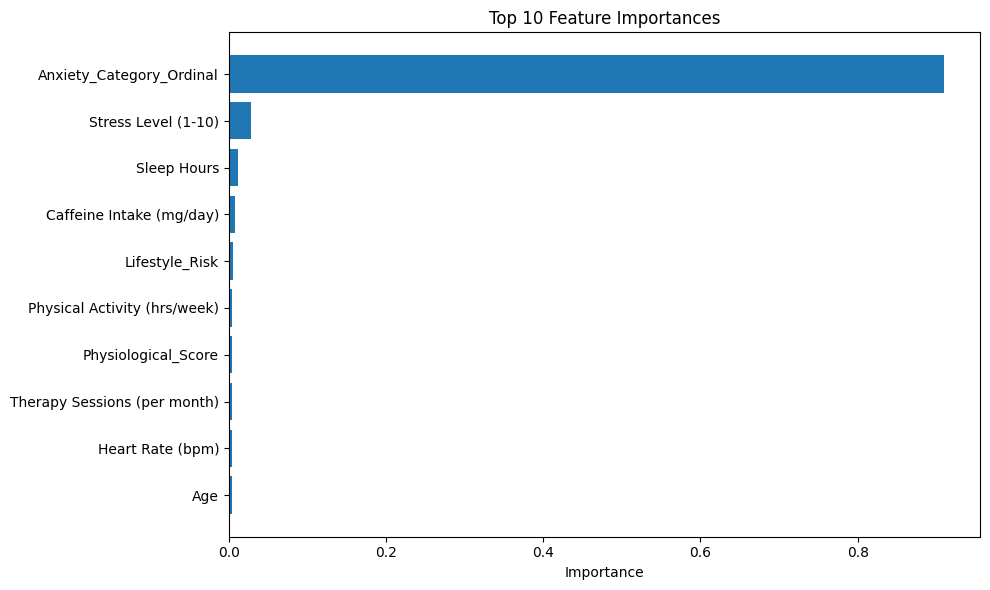

In [14]:
#  Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train_full.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance.head(10)['feature'], feature_importance.head(10)['importance'])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

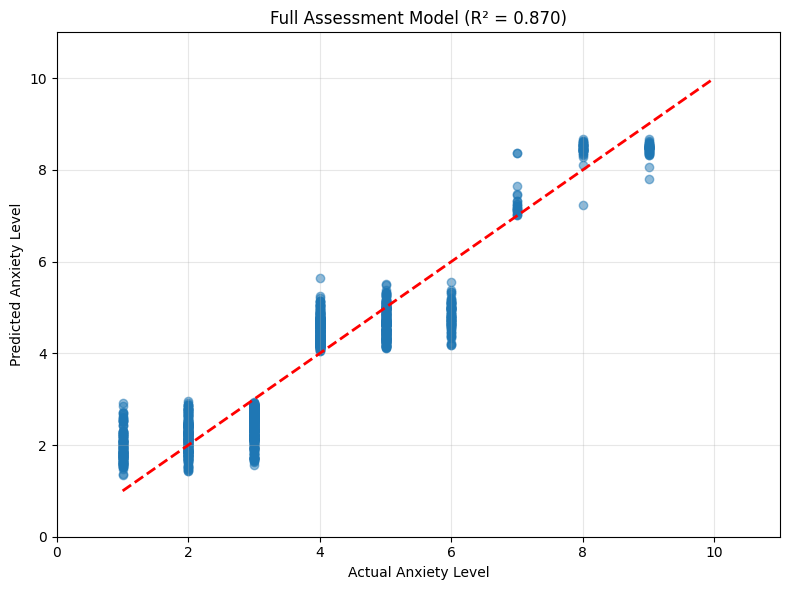

In [15]:
# Cell 12: Prediction vs Actual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_test, alpha=0.5)
plt.plot([1, 10], [1, 10], 'r--', lw=2)
plt.xlabel('Actual Anxiety Level')
plt.ylabel('Predicted Anxiety Level')
plt.title(f'Full Assessment Model (R² = {r2_test:.3f})')
plt.xlim(0, 11)
plt.ylim(0, 11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('full_model_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# Cell 13: Save Full Assessment Model
model_path = '/content/drive/MyDrive/SentiCare_Project/02_Trained_Models'
import os
os.makedirs(model_path, exist_ok=True)

joblib.dump(best_rf, f'{model_path}/assessment_model.pkl')
print(f"✓ Model saved: {model_path}/assessment_model.pkl")

✓ Model saved: /content/drive/MyDrive/SentiCare_Project/02_Trained_Models/assessment_model.pkl


In [18]:
# : Train baseline Logistic Regression (Real-Time Model)
print("="*60)
print("MODEL 2: REAL-TIME EMOTION (Logistic Regression)")
print("="*60)

lr_baseline = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_baseline.fit(X_train_realtime, y_train_class)

y_pred_val_lr = lr_baseline.predict(X_val_realtime)
acc_val = accuracy_score(y_val_class, y_pred_val_lr)
precision, recall, f1, _ = precision_recall_fscore_support(y_val_class, y_pred_val_lr, average='weighted')

print(f"Validation Accuracy: {acc_val:.3f}")
print(f"Validation Precision: {precision:.3f}")
print(f"Validation Recall: {recall:.3f}")
print(f"Validation F1-Score: {f1:.3f}")

MODEL 2: REAL-TIME EMOTION (Logistic Regression)
Validation Accuracy: 0.719
Validation Precision: 0.717
Validation Recall: 0.719
Validation F1-Score: 0.713


In [19]:
# Cell 15: Hyperparameter tuning Logistic Regression
print("Tuning Logistic Regression hyperparameters...")

param_grid_lr = {
    'C': [0.1, 1.0, 10.0],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

grid_search_lr = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    param_grid_lr,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search_lr.fit(X_train_realtime, y_train_class)
best_lr = grid_search_lr.best_estimator_

print(f"Best parameters: {grid_search_lr.best_params_}")

y_pred_val_tuned_lr = best_lr.predict(X_val_realtime)
acc_tuned = accuracy_score(y_val_class, y_pred_val_tuned_lr)
precision_tuned, recall_tuned, f1_tuned, _ = precision_recall_fscore_support(
    y_val_class, y_pred_val_tuned_lr, average='weighted'
)

print(f"Tuned Validation Accuracy: {acc_tuned:.3f}")
print(f"Tuned Validation F1-Score: {f1_tuned:.3f}")

Tuning Logistic Regression hyperparameters...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
Tuned Validation Accuracy: 0.718
Tuned Validation F1-Score: 0.712


In [20]:
#  Final evaluation on test set (Real-Time Model)
y_pred_test_lr = best_lr.predict(X_test_realtime)
acc_test = accuracy_score(y_test_class, y_pred_test_lr)
precision_test, recall_test, f1_test, _ = precision_recall_fscore_support(
    y_test_class, y_pred_test_lr, average='weighted'
)

print("="*60)
print("FINAL TEST SET PERFORMANCE (Real-Time Model)")
print("="*60)
print(f"Test Accuracy: {acc_test:.3f}")
print(f"Test Precision: {precision_test:.3f}")
print(f"Test Recall: {recall_test:.3f}")
print(f"Test F1-Score: {f1_test:.3f}")

FINAL TEST SET PERFORMANCE (Real-Time Model)
Test Accuracy: 0.731
Test Precision: 0.728
Test Recall: 0.731
Test F1-Score: 0.725


In [21]:
#  Classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test_class, y_pred_test_lr))


Detailed Classification Report:
              precision    recall  f1-score   support

        mild       0.80      0.78      0.79       777
    moderate       0.68      0.75      0.71       698
      severe       0.55      0.28      0.37       114

    accuracy                           0.73      1589
   macro avg       0.68      0.60      0.62      1589
weighted avg       0.73      0.73      0.73      1589



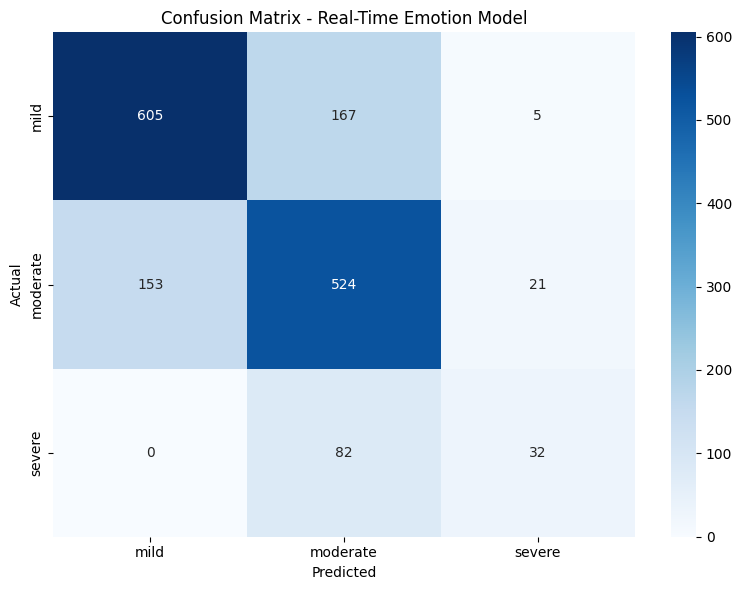

In [22]:
# Confusion matrix
cm = confusion_matrix(y_test_class, y_pred_test_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['mild', 'moderate', 'severe'],
            yticklabels=['mild', 'moderate', 'severe'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Real-Time Emotion Model')
plt.tight_layout()
plt.savefig('realtime_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
#Save Real-Time Model
joblib.dump(best_lr, f'{model_path}/realtime_emotion_model.pkl')
print(f"✓ Model saved: {model_path}/realtime_emotion_model.pkl")

✓ Model saved: /content/drive/MyDrive/SentiCare_Project/02_Trained_Models/realtime_emotion_model.pkl


In [24]:
#Compare both models
results_summary = pd.DataFrame({
    'Model': ['Full Assessment (RF)', 'Real-Time (LR)'],
    'Features': [33, 6],
    'Task': ['Regression (1-10)', 'Classification (3 classes)'],
    'Primary Metric': [f'RMSE: {rmse_test:.3f}', f'Accuracy: {acc_test:.3f}'],
    'Secondary Metric': [f'R²: {r2_test:.3f}', f'F1: {f1_test:.3f}'],
    'Test Samples': [len(y_test_reg), len(y_test_class)]
})

print("="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(results_summary.to_string(index=False))

MODEL COMPARISON SUMMARY
               Model  Features                       Task  Primary Metric Secondary Metric  Test Samples
Full Assessment (RF)        33          Regression (1-10)     RMSE: 0.666        R²: 0.870          1589
      Real-Time (LR)         6 Classification (3 classes) Accuracy: 0.731        F1: 0.725          1589


In [26]:
# Test single prediction (Real-Time)
sample_idx = 0 # Define sample_idx for testing a single prediction
sample_features_rt = X_test_realtime.iloc[sample_idx:sample_idx+1]
actual_category = y_test_class[sample_idx]
predicted_category = best_lr.predict(sample_features_rt)[0]
predicted_probs = best_lr.predict_proba(sample_features_rt)[0]

print("="*60)
print("SINGLE PREDICTION TEST (Real-Time)")
print("="*60)
print(f"Sample features shape: {sample_features_rt.shape}")
print(f"Actual category: {actual_category}")
print(f"Predicted category: {predicted_category}")
print(f"Prediction probabilities:")
for cls, prob in zip(best_lr.classes_, predicted_probs):
    print(f"  {cls}: {prob:.3f}")

SINGLE PREDICTION TEST (Real-Time)
Sample features shape: (1, 6)
Actual category: moderate
Predicted category: moderate
Prediction probabilities:
  mild: 0.082
  moderate: 0.462
  severe: 0.455


In [27]:
#  Save model metadata
metadata = {
    'full_assessment_model': {
        'algorithm': 'Random Forest Regressor',
        'features': 33,
        'samples_train': len(X_train_full),
        'samples_test': len(X_test_full),
        'test_rmse': float(rmse_test),
        'test_mae': float(mae_test),
        'test_r2': float(r2_test),
        'best_params': grid_search.best_params_
    },
    'realtime_model': {
        'algorithm': 'Logistic Regression',
        'features': 6,
        'samples_train': len(X_train_realtime),
        'samples_test': len(X_test_realtime),
        'test_accuracy': float(acc_test),
        'test_f1': float(f1_test),
        'best_params': grid_search_lr.best_params_
    }
}

import json
with open(f'{model_path}/model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("✓ Metadata saved: model_metadata.json")

✓ Metadata saved: model_metadata.json


In [29]:
# Final summary
print("="*60)
print("PHASE 2A COMPLETE - MODELS TRAINED")
print("="*60)
print("\n✓ Files created:")
print(f"  • {model_path}/assessment_model.pkl")
print(f"  • {model_path}/realtime_emotion_model.pkl")
print(f"  • {model_path}/model_metadata.json")
print(f"  • feature_importance.png")
print(f"  • full_model_predictions.png")
print(f"  • realtime_confusion_matrix.png")
print("\n✓ Performance Summary:")
print(f"  • Full Assessment RMSE: {rmse_test:.3f} (Target: < 1.0)")
print(f"  • Full Assessment R²: {r2_test:.3f} (Target: > 0.70)")
print(f"  • Real-Time Accuracy: {acc_test:.3f} (Target: > 0.75)")
print(f"  • Real-Time F1: {f1_test:.3f}")



PHASE 2A COMPLETE - MODELS TRAINED

✓ Files created:
  • /content/drive/MyDrive/SentiCare_Project/02_Trained_Models/assessment_model.pkl
  • /content/drive/MyDrive/SentiCare_Project/02_Trained_Models/realtime_emotion_model.pkl
  • /content/drive/MyDrive/SentiCare_Project/02_Trained_Models/model_metadata.json
  • feature_importance.png
  • full_model_predictions.png
  • realtime_confusion_matrix.png

✓ Performance Summary:
  • Full Assessment RMSE: 0.666 (Target: < 1.0)
  • Full Assessment R²: 0.870 (Target: > 0.70)
  • Real-Time Accuracy: 0.731 (Target: > 0.75)
  • Real-Time F1: 0.725

✓ Next steps:
